Nurvirta Monarizqa 
3/8/2020

Plot kasus aktif Covid-19 harian per provinsi
Style: https://www.endcoronavirus.org/states
Data: kawalcovid19.id

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import rcParams
%matplotlib inline

import seaborn as sns
sns.set_style("white")
rcParams['font.family'] = 'monospace'
import numpy as np
from sklearn.cluster import KMeans



# 1. Load Data

## 1.a. Letak Provinsi dalam grid

In [2]:
indo_grid = pd.read_csv("assets/indo_grid.csv", index_col=0)
indo_grid.index = range(len(indo_grid))
indo_grid.columns =range(len(indo_grid.columns))
indo_index = indo_grid.T.stack()

## 1.b. Kasus dari kawalcovid19.id
https://docs.google.com/spreadsheets/d/1ma1T9hWbec1pXlwZ89WakRk-OfVUQZsOCFl4FwZxzVw/edit
Tab "Timeline"

In [3]:
data = pd.read_csv("kawalcovid/20200803.csv")
ix_sep = data[data.Aceh=="Aceh"]['Total Kasus'].index
ix_sep

Int64Index([140, 284, 422, 560, 698, 839], dtype='int64')

In [4]:
data[data.Aceh=="Aceh"]

,Total Kasus,Aceh,Bali,Banten,Babel,Bengkulu,DIY,Jakarta,Jambi,Jabar,...,Lampung,Riau,Malut,Maluku,Papbar,Papua,Sulbar,NTT,Gorontalo,?
140,Kasus Harian,Aceh,Bali,Banten,Babel,Bengkulu,DIY,Jakarta,Jambi,Jabar,...,Lampung,Riau,Malut,Maluku,Papbar,Papua,Sulbar,NTT,Gorontalo,?
284,Kasus Aktif,Aceh,Bali,Banten,Babel,Bengkulu,DIY,Jakarta,Jambi,Jabar,...,Lampung,Riau,Malut,Maluku,Papbar,Papua,Sulbar,NTT,Gorontalo,?
422,Sembuh,Aceh,Bali,Banten,Babel,Bengkulu,DIY,Jakarta,Jambi,Jabar,...,Lampung,Riau,Malut,Maluku,Papbar,Papua,Sulbar,NTT,Gorontalo,?
560,Sembuh Harian,Aceh,Bali,Banten,Babel,Bengkulu,DIY,Jakarta,Jambi,Jabar,...,Lampung,Riau,Malut,Maluku,Papbar,Papua,Sulbar,NTT,Gorontalo,?
698,Meninggal Dunia,Aceh,Bali,Banten,Babel,Bengkulu,DIY,Jakarta,Jambi,Jabar,...,Lampung,Riau,Malut,Maluku,Papbar,Papua,Sulbar,NTT,Gorontalo,?
839,Meninggal Dunia Harian,Aceh,Bali,Banten,Babel,Bengkulu,DIY,Jakarta,Jambi,Jabar,...,Lampung,Riau,Malut,Maluku,Papbar,Papua,Sulbar,NTT,Gorontalo,?


Dari dataframe di atas terlihat bahwa di satu sheet terdapat beberapa tabel, mari kita pisahkan dengan keberadaan header di tiap tabel sebagai penentu (ix_sep)

In [5]:
total_kasus = data.iloc[:ix_sep[0]-1,:].set_index("Total Kasus")
kasus_harian = data.iloc[ix_sep[0]+1:ix_sep[1]-1,:].set_index("Total Kasus")
kasus_aktif = data.iloc[ix_sep[1]+1:ix_sep[2]-1,:].set_index("Total Kasus")
sembuh = data.iloc[ix_sep[2]+1:ix_sep[3]-1,:].set_index("Total Kasus")
sembuh_harian = data.iloc[ix_sep[3]-1:ix_sep[4]+1,:].set_index("Total Kasus")
meninggal = data.iloc[ix_sep[4]-1:ix_sep[5]+1,:].set_index("Total Kasus")
meninggal_harian = data.iloc[ix_sep[5]-1:,:].set_index("Total Kasus")

In [6]:
total_kasus.head()

,Aceh,Bali,Banten,Babel,Bengkulu,DIY,Jakarta,Jambi,Jabar,Jateng,...,Lampung,Riau,Malut,Maluku,Papbar,Papua,Sulbar,NTT,Gorontalo,?
Total Kasus,,,,,,,,,,,,,,,,,,,,,
18-Mar,0,1,17,0,0,3,158,0,24,8,...,1,1,0,0,0,0,0,0,0,0
19-Mar,0,1,27,0,0,5,210,0,26,12,...,1,2,0,0,0,0,0,0,0,0
20-Mar,0,4,37,0,0,4,215,0,41,12,...,1,1,0,0,0,0,0,0,0,13
21-Mar,0,3,43,0,0,5,267,0,55,14,...,1,1,0,0,0,0,0,0,0,10
22-Mar,0,3,47,0,0,5,307,0,59,15,...,1,1,0,1,0,2,0,0,0,6


# 2. Olah Data

## 2.a. Convert data to numeric, simpan rolling average (7 hari)

Kali ini, hanya kasus_aktif yang akan diproses

In [7]:
col = kasus_aktif.columns
all_data = []
all_data_rolling = []
for i in range(34):
    the_data = pd.to_numeric(kasus_aktif[col[i]].apply(lambda x: x.replace(",","")))
    the_data_rolling = the_data.rolling(7).mean()
    all_data.append(the_data)
    all_data_rolling.append(the_data_rolling)
aktif = pd.concat(all_data, axis=1)
aktif_rolling = pd.concat(all_data_rolling, axis=1).dropna()
aktif.index = pd.to_datetime(pd.Series([x+"-2020" for x in aktif.index]))
aktif_rolling.index = pd.to_datetime(pd.Series([x+"-2020" for x in aktif_rolling.index]))

## 2.b. Melakukan clustering untuk mengelompokkan timeseries dan memberi skor

In [8]:
X=((aktif_rolling-aktif_rolling.mean(axis=0))/aktif_rolling.std(axis=0)).T
km = KMeans(5, random_state=2)
clusters = pd.Series(km.fit(X).predict(X), index=X.index)

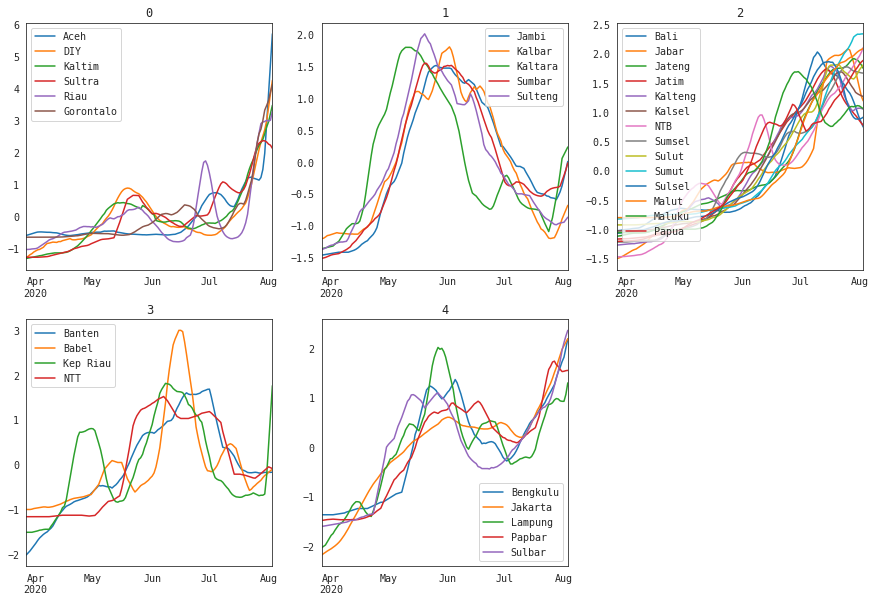

In [9]:
fig = plt.figure(figsize=(15,10))
for i in range(5):
    ax = fig.add_subplot(231+i)
    cols = clusters[clusters==i].index
    X.T[cols].plot(ax=ax)
    ax.set_title(str(i))

Mari kita beri warna, cluster 0,4,2 seharusnya berwarna merah dan cluster 3,1 berwarna kuning

In [10]:
reds = [0,4,2]
yellows = [3,1]

cluster_order = {}
for c in reds:
    cluster_order[c] = "red"
for c in yellows:
    cluster_order[c] = "yellow"

## 2. c. Kumpulkan semua info

In [11]:
# val adalah variable yang membandingkan nilai kasus aktif maksimum dengan nilai kasus terkini
# jika val == 1, maka kasusnya terus naik
# jika val < 1, maka sudah terjadi penurunan
val  = (aktif_rolling.tail(1)/aktif_rolling.max()).iloc[0].sort_values()

In [12]:
# info berisi grid lokasi tiap provinis, cluster, dan val
# cluster rank adalah penentu warna, berdasar reds dan yellow
# cluster color untuk cluster reds (0,4,2) adalah red sisanya (3,1) adalah yellow
info = pd.concat([clusters,val],axis=1)
info.columns = ['cluster','score']
info['cluster_color'] = info.cluster.apply(lambda x: cluster_order[x])
info = info.sort_values(["cluster_color","score"])
info = pd.concat([info, indo_index.reset_index().set_index(0)], axis=1).dropna()

In [13]:
info

,cluster,score,cluster_color,level_0,level_1
Bali,2.0,0.582454,red,8,6
Jatim,2.0,0.671970,red,6,6
Sulsel,2.0,0.677601,red,8,4
Jabar,2.0,0.756065,red,4,6
Kalteng,2.0,0.761260,red,5,3
Maluku,2.0,0.769930,red,12,3
Lampung,4.0,0.827740,red,1,5
Kalsel,2.0,0.845321,red,6,4
Sultra,0.0,0.934941,red,10,4
Papbar,4.0,0.942164,red,14,2


Semua cluster yellow seharusnya memiliki val < 1, hanya saja Kep Riau terlihat tidak signifikan, seharusnya masuk golongan red. 

Sebaliknya, Bali memiliki penurunan signifikan (0,58) namun tidak termasuk yellow. Sehingga mari kita perbaiki secara manual berikut ini

In [14]:

info.loc["Kep Riau","cluster_rank"] = 2
info.loc["Bali","cluster_rank"] = 3

Ada banyak cara untuk membuat kategori merah, kuning, dan hijau. Paling benar apabila memperhatikan pertumbuhan grafik tidak hanya bentuknya saja. Namun untuk mini project kali ini, saya gunakan cluster untuk mempermudah.

# 3. Plot

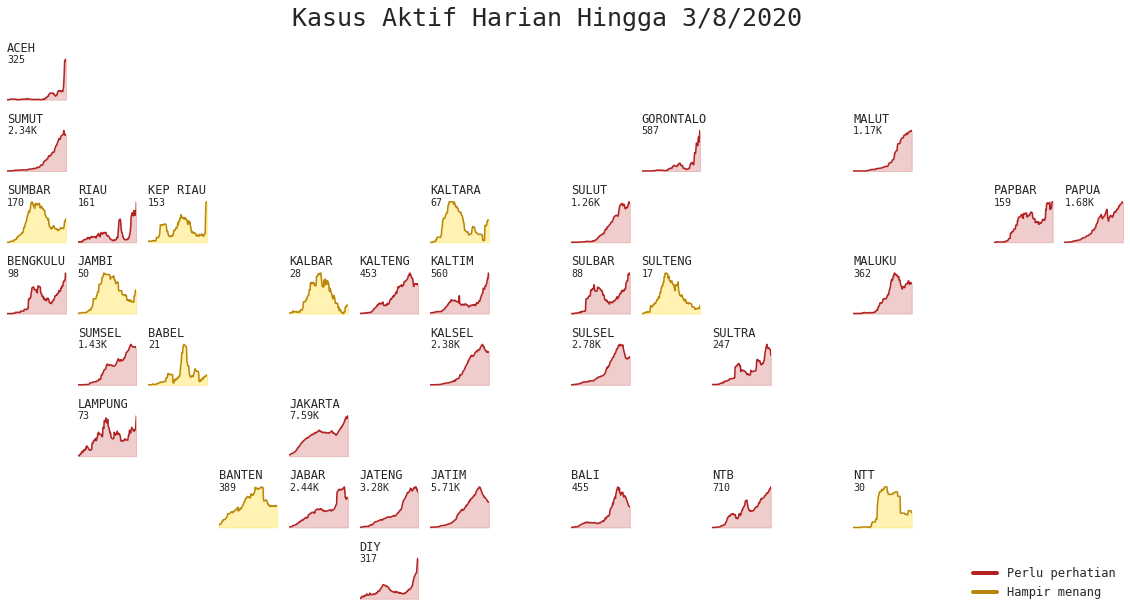

In [15]:
fig, axs = plt.subplots(8,16, figsize=(20,10))
for col in info.index:
    # subset data
    the_data = aktif.loc[:,col]
    cluster_color = info.loc[col]['cluster_color']
    if cluster_color == "red":
        colorfill = "indianred"
        color = "firebrick"
    else:
        color = "darkgoldenrod"
        colorfill = "gold"
        
    # grid positioning
    y = int(info.loc[col]['level_0'])
    x = int(info.loc[col]['level_1'])
    ax = axs[x,y]
    
    # plot data
    the_data.plot(ax=ax, color=color)
    ax.set_title(col.upper(), x=0,y=1, fontsize=12, loc='left')
    ax.set_xlabel("")
    l1 = ax.lines[0]
    x1 = l1.get_xydata()[:,0]
    y1 = l1.get_xydata()[:,1]
    ax.fill_between(x1,y1, color=colorfill, alpha=0.3)
    
    # number and label styling
    number = int(y1[-1])
    if number > 1000:
        numbertext = str(np.round(np.float(y1[-1]/1000),2))+"K"
    else:
        numbertext = str(number)
    ax.text(x=0,y=0.88,s=numbertext, transform=ax.transAxes, 
            fontsize=10)
    
# hapus semua border untuk subplot lain
for row in axs:
    for ax in row:
        plt.subplots_adjust(hspace = 0.6)
        ax.axis("off")

# judul
plt.suptitle("Kasus Aktif Harian Hingga 3/8/2020", fontsize=25, y=0.95)
legend_elements = [Line2D([0], [0], color='firebrick', lw=4, label='Perlu perhatian'),
                   Line2D([0], [0], color='darkgoldenrod', lw=4, label='Hampir menang')]

# legenda
leg = plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), fontsize=12)
leg.get_frame().set_linewidth(0.0)